# Land Use Classification

In this notebook, we train a classifier to distinguish between 10 categories of land use on 64x64 images of resolution 10m/pixel. We will use the saliency maps from this generator to retrain albu's model on the Urban 3D dataset (50cm/pixel) without depth mappings.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

Instead of using pure PyTorch, we are utilizing the increasingly popular fastai library built on top of it. Fastai integrates many best-practices of deep learning into simple function calls, thus making it easier to build on the contributions to the field.

In [7]:
import fastai
from fastai.vision import *
import torch

Here we create our dataset from the EuroSat dataset folder by randomly creating a train/validation set, then labelling each file with the correct land use classification based upon its folder name.

For reference, here is the structure of the Eurosat dataset.

In [24]:
!tree -d 1 ../EuroSat/

1 [error opening dir]
../EuroSat/
├── AnnualCrop
├── Forest
├── HerbaceousVegetation
├── Highway
├── Industrial
├── models
├── Pasture
├── PermanentCrop
├── Residential
├── River
└── SeaLake

11 directories


In [8]:
tfms = get_transforms(max_warp=0.0) # Applies fast.ai's default transforms
data = (ImageItemList.from_folder(datadir, recurse=True)
        .random_split_by_pct() # Train/Validation is 0.8/0.2 % of dataset
        .label_from_folder()
        .transform(tfms)
        .databunch() # Make into Fast.ai's dataset object
        .normalize([torch.tensor(0.0), torch.tensor(255.0)]) # Set range 0-1
       )

To see some of the images.

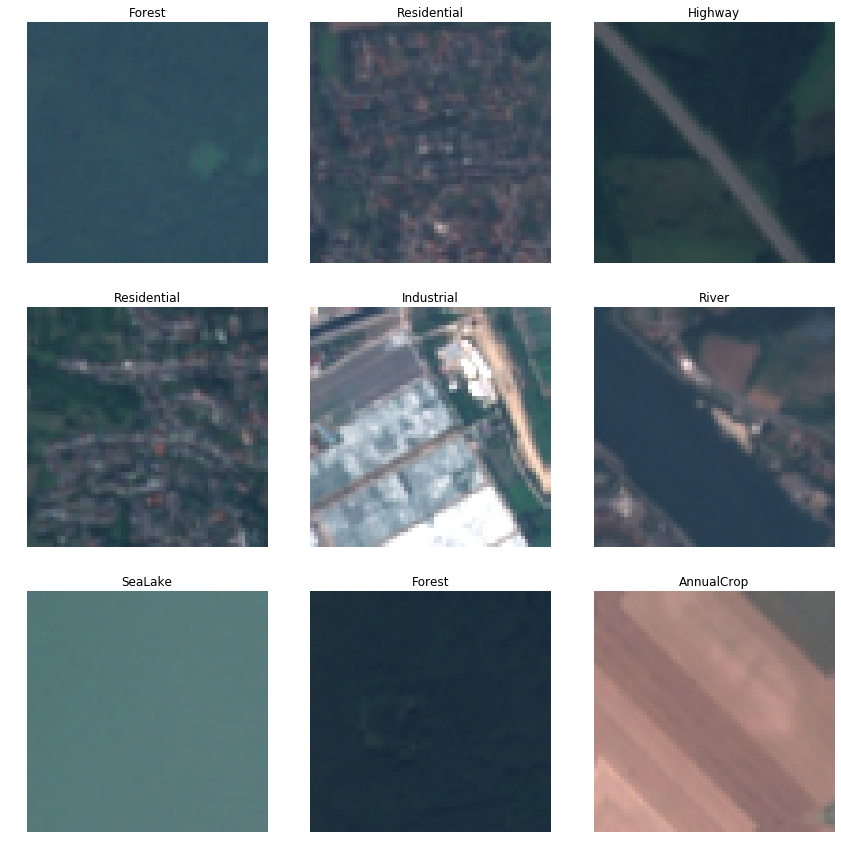

In [9]:
data.show_batch(rows=3)

## Model Building

Here we utilize the special WideResnet architecture, which is meant to be more computationally efficient than its (thin) Resnet predecessors.

#### Finding the right learning rate

Here's a technique that fastai implements that the rest of the deep learning community is sorely missing out on: cyclical learning rates. As detailed in Leslie Smith's paper on Cyclical Learning Rates, one can achieve faster rates of converge by annealing the LR between a max and a min value over cycles of $N$ epochs. To find the `lr_max` that we use in cyclical training, we train over 1 epoch, and gradually increase the learning rate and see how it affects loss. We choose our `lr_max` to be a value before the loss stops decreasing. 

In the original paper, cycle lengths are increased geometrically. We choose a multiple of 2 and that's what we aim to emulate by running `learn.fit_one_cycle(1, ...), learn.fit_one_cycle(2, ...), learn.fit_one_cycle(4, ...), etc`. The best accuracy on this dataset (in the paper that introduced it) was 98%, so that's what we aim for.

Note: the actual implementation of the cyclical learning rates has been further modified by the fastai community, such as by cosine-annealing (rather than linearly), and by flipping the momentum at the peaks & valleys of the learning rate. The handling of learning rates is extremely important for model training, and this method was responsible for [training ImageNet in <18 minutes.](https://www.fast.ai/2018/08/10/fastai-diu-imagenet/).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


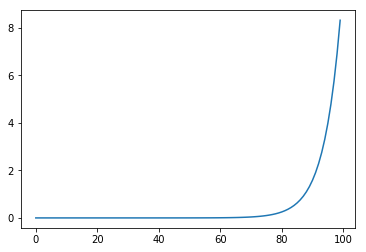

In [18]:
learn = Learner(data, models.wrn_22(), metrics=accuracy)
learn.lr_find()

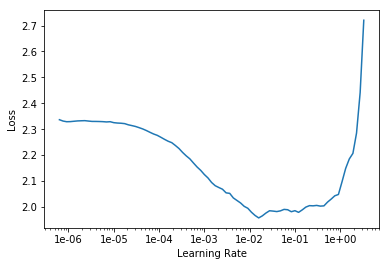

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.914442,0.758746,0.716482


In [21]:
learn.fit_one_cycle(2, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.769716,0.895069,0.697778
2,0.503044,0.514377,0.819259


In [25]:
learn.fit_one_cycle(4, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.614662,1.164028,0.627778
2,0.538662,0.849929,0.730556
3,0.390744,0.407114,0.855370
4,0.289345,0.300072,0.898519


In [26]:
learn.fit_one_cycle(8, 5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.311796,0.338442,0.881667
2,0.388541,0.653132,0.770926
3,0.326005,0.280039,0.913333
4,0.286087,0.285931,0.902407
5,0.228719,0.357044,0.887407
6,0.167089,0.151281,0.947778
7,0.116362,0.127569,0.955370
8,0.111740,0.126280,0.957778


In [27]:
learn.save("wrn22-95")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


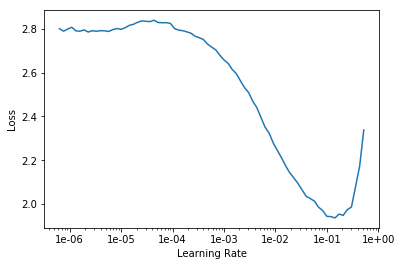

In [34]:
learn = create_cnn(data, models.resnet18, pretrained=True, metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,0.387398,0.238003,0.920926


In [36]:
learn.fit_one_cycle(2, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,1.087844,0.869517,0.740926
2,0.420277,0.333945,0.885926


In [37]:
learn.fit_one_cycle(4, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,0.664072,1.094046,0.739630
2,0.543449,0.838406,0.795000
3,0.336841,0.389150,0.880370
4,0.241402,0.208634,0.931852


In [38]:
learn.fit_one_cycle_cycle(8, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,0.288489,0.396092,0.896296
2,0.584473,0.770916,0.789259
3,0.559062,1.016490,0.738889
4,0.511552,1.141820,0.811667
5,0.381858,0.406867,0.880926
6,0.311754,0.244279,0.924259
7,0.228885,0.196140,0.931481
8,0.201833,0.347839,0.939630


In [39]:
learn.fit_one_cycle(16, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.218437,0.185390,0.937593
2,0.189176,0.283802,0.936852
3,0.219381,0.287289,0.915370
4,0.227950,0.246466,0.928333
5,0.226961,0.332897,0.929444
6,0.215557,0.346211,0.936667
7,0.232657,0.215501,0.932222
8,0.246864,0.247358,0.925000
9,0.204530,0.166685,0.944444
10,0.204024,0.207131,0.935556


In [41]:
learn.save('resnet18-94')

In [44]:
learn = create_cnn(data, models.resnet18, pretrained=True, metrics=accuracy)
learn.fit(10)

epoch,train_loss,valid_loss,accuracy
1,0.556920,0.407128,0.861481
2,0.398373,0.304992,0.897407
3,0.346571,0.262681,0.912593
4,0.317357,0.247446,0.920926
5,0.291867,0.211366,0.931296
6,0.263926,0.224543,0.925741
7,0.247732,0.192995,0.939815
8,0.223845,0.180133,0.943889
9,0.219154,0.174063,0.945370
10,0.221967,0.174456,0.943704


In [45]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.294235,0.207487,0.929630
2,0.287519,0.204897,0.929259
3,0.228969,0.172610,0.939444
4,0.160240,0.132668,0.955000
5,0.139375,0.115178,0.959630


In [46]:
learn.save('resnet18-96')

In [47]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.182561,0.379046,0.870926
2,0.244198,0.318484,0.902037
3,0.195326,0.149519,0.951296
4,0.155877,0.111782,0.962963
5,0.113499,0.123151,0.959815


In [48]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,accuracy
1,0.133407,0.198232,0.932407
2,0.166050,0.208095,0.933704
3,0.155600,0.113964,0.962407
4,0.118043,0.118578,0.961296
5,0.103678,0.108901,0.965185


In [49]:
learn.save('resnet18-96')

In [122]:
xs, ys = data.one_batch()

def plot_saliency(xs, ys, learn, nrows=2, ncols=5, figsize=(18,6)):
    if len(xs) != nrows * ncols or len(ys) != nrows * ncols:
        raise ValueError("xs/ys need to have the exact same number of elements as nrows*ncols")
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols*2, figsize=figsize)
    do_sal = 0
    for i, ax in enumerate(axes.ravel()):
        idx = i // 2
        if do_sal:
            input_var = torch.autograd.Variable(xs[idx].unsqueeze(0).cuda(), requires_grad=True)
            out = learn.model(input_var)
            loss = learn.loss_func.func(out, ys[idx].unsqueeze(0).cuda())
            loss.backward()
            sal = np.transpose(input_var.grad.data.detach().cpu().numpy().squeeze(), (1, 2, 0))
            abs_sal = np.abs(sal).max(axis=2)
            ax.imshow(abs_sal)
        else:
            ax.imshow(np.transpose(xs[idx].numpy(), (1, 2, 0)))
        ax.set_title(f"{data.classes[ys[idx]]}")
        ax.set_xticks([])
        ax.set_yticks([])
        do_sal = 1 - do_sal
    fig.tight_layout()

plot_pref = {
    'nrows': 3,
    'ncols': 2,
}
MAX_NUM=plot_pref['nrows']*plot_pref['ncols']

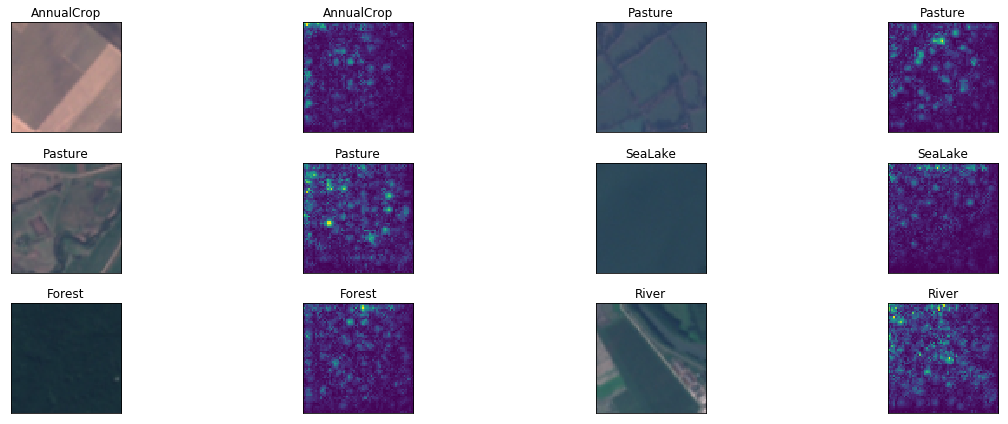

In [123]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.model = learn.model.eval()
learn.load('resnet18-96')
plot_saliency(xs[:MAX_NUM], ys[:MAX_NUM], learn, **plot_pref)

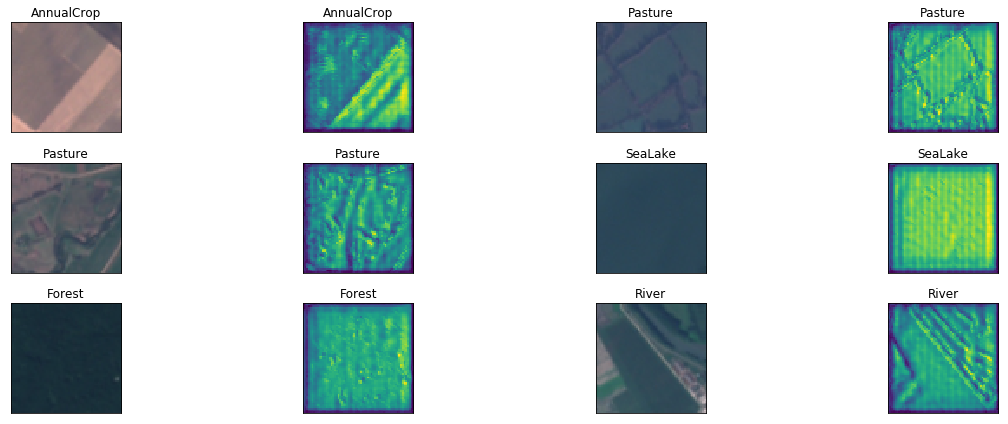

In [124]:
learn = Learner(data, models.wrn_22())
learn.load('wrn22-95')
learn.model = learn.model.eval()
plot_saliency(xs[:MAX_NUM], ys[:MAX_NUM], learn, **plot_pref)

# Deprecated Utilities

The following code snippets are used to load in data into numpy without the help of the fastai framework. This code is saved, in case it is needed for further scripting.

In [2]:
datadir='../EuroSat/'
categories = []
cat2idx = {}
with open("cat2idx.txt", "r") as f:
    for line in f:
        cat, idx = line.strip().split(":")
        categories.append(cat)
        cat2idx[cat] = int(idx)
        print(datadir+cat, "exists:", os.path.isdir(datadir+cat))

../EuroSat/Residential exists: True
../EuroSat/Pasture exists: True
../EuroSat/Industrial exists: True
../EuroSat/HerbaceousVegetation exists: True
../EuroSat/PermanentCrop exists: True
../EuroSat/SeaLake exists: True
../EuroSat/River exists: True
../EuroSat/AnnualCrop exists: True
../EuroSat/Forest exists: True
../EuroSat/Highway exists: True


Load in the files according to their label

In [3]:
fnames = []
labels = []
for cat in categories:
    for name in os.listdir(datadir+cat):
        fnames.append(name)
        labels.append(cat2idx[cat])

In [4]:
labels = np.array(labels)
for i in range(len(categories)):
    print(f"There are {np.sum(labels==i)} images of {categories[i]}.")

There are 3000 images of Residential.
There are 2000 images of Pasture.
There are 2500 images of Industrial.
There are 3000 images of HerbaceousVegetation.
There are 2500 images of PermanentCrop.
There are 3000 images of SeaLake.
There are 2500 images of River.
There are 3000 images of AnnualCrop.
There are 3000 images of Forest.
There are 2500 images of Highway.


In [5]:
def load_img(index):
    """Loads an image into memory based upon the index, by piecing together pathname
    from global variables (datadir, categories, labels, fnames)"""
    path2img = os.path.join(datadir, categories[labels[index]], fnames[index])
    # CV2 reads in images BGR, we want RGB
    bgr = cv2.imread(path2img, cv2.IMREAD_COLOR)
    return np.dstack((bgr[...,-1], bgr[...,1], bgr[...,0]))